In [1]:
import numpy as np 
import pandas as pd  
from matplotlib import pyplot as plt, ticker as mticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import re
import utils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(CVXPY) Feb 26 08:36:20 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 26 08:36:20 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
df = pd.read_csv('../Datasets/titanic.csv')
print(df.shape)
df.head()

(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1047, 13), (1047,), (262, 13), (262,))

In [4]:
def preprocessing(X):

    # 1. Drop features that are not needed
    X = X.drop(columns=['ticket', 'fare', 'boat', 'body', 'home.dest'], axis=1)

    # 2. Make 'cabin' less granular and more meaningful
    X['cabin'] = [i[0] if pd.notna(i) else np.nan for i in X['cabin']]

    # 3. Create a new feature called "title" and drop the name column 
    pattern = r',\s*([A-Za-z]+)\.'
    X['title'] = X['name'].str.extract(pattern, expand=False)
    X = X.drop(['name'], axis=1)

    # 4. Transform 'pclass' from a numerical to a categorical feature
    X['pclass'] = X['pclass'].astype('str')

    return X

In [5]:
preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.transform(X_train)

In [6]:
df_missing = pd.DataFrame(X_train.isna().mean().sort_values(ascending=False), columns=['missing_pct'])
df_missing['dtype'] = [X_train[var].dtype for var in df_missing.index]
df_missing['exclude'] = [1 if i >= 0.2 else 0 for i in df_missing['missing_pct']]
df_missing

,missing_pct,dtype,exclude
cabin,0.776504,object,1
age,0.197708,float64,0
embarked,0.000955,object,0
title,0.000955,object,0
pclass,0.000000,object,0
sex,0.000000,object,0
sibsp,0.000000,int64,0
parch,0.000000,int64,0


In [7]:
variables_num = [var for var in X_train.columns if X_train[var].dtype != 'O']
variables_cat = [var for var in X_train.columns if var not in variables_num]

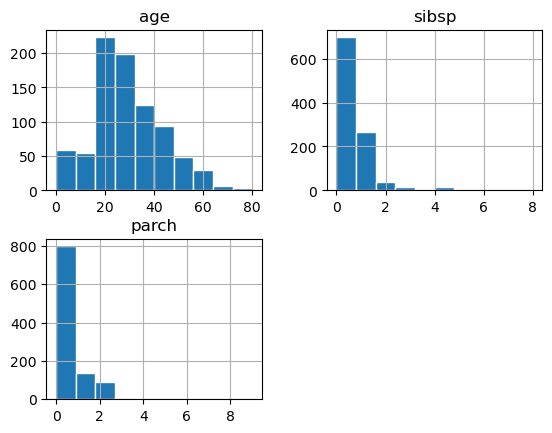

In [8]:
X_train[variables_num].hist(ec='white');

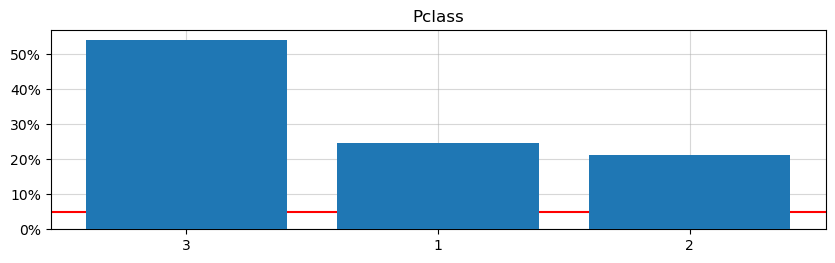

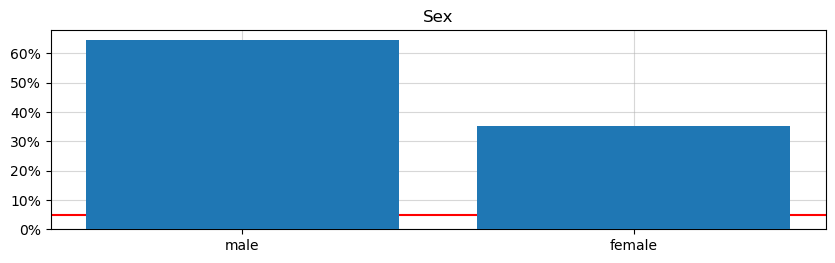

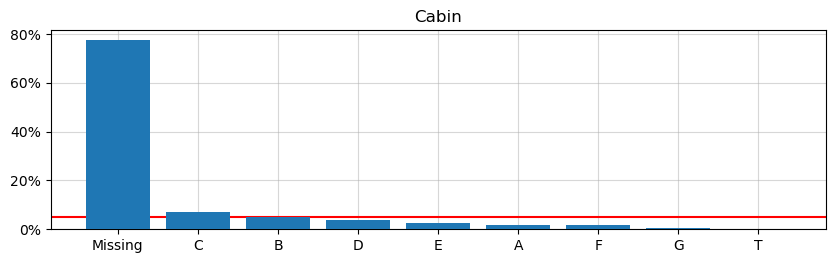

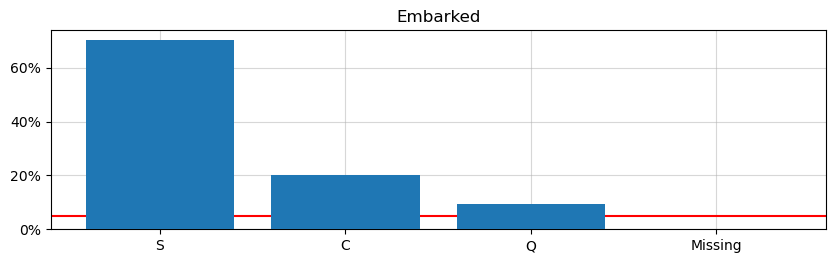

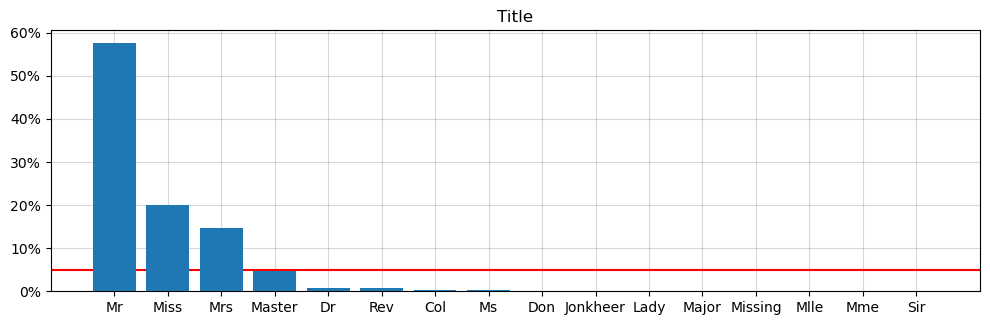

In [9]:
for i, var in enumerate(variables_cat):
    data = X_train.copy()
    data = data.fillna('Missing')
    data = pd.DataFrame(data.groupby(var, dropna=False)[var].count().sort_values(ascending=False) / data.shape[0])
    plt.figure(figsize=(10, len(variables_cat)*3))
    plt.subplot(len(variables_cat), 1, i+1)
    plt.bar(x=data.index.tolist(), height=data[var], zorder=5)
    plt.title(var.title())
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.axhline(y=0.05, color='red')
    plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
y_train.groupby(X_train['title']).mean().sort_values(ascending=False)

title
Lady        1.000000
Mlle        1.000000
Mme         1.000000
Sir         1.000000
Mrs         0.777778
Miss        0.661905
Col         0.500000
Dr          0.500000
Master      0.500000
Ms          0.500000
Mr          0.144040
Don         0.000000
Jonkheer    0.000000
Major       0.000000
Rev         0.000000
Name: survived, dtype: float64

### Encoding of categorical features: 
1. pclass  
2. sex  
3. embarked  
4. title  



## Optbinning 

### Load data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.2,
                                                    random_state=42)

### Preprocess X_train

In [12]:
preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.fit_transform(X_train)
X_train.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
772,3,male,17.0,0,0,NaN,S,Mr
543,2,male,36.0,0,0,NaN,S,Mr
289,1,female,18.0,0,2,E,S,Miss
10,1,male,47.0,1,0,C,C,Col
147,1,male,NaN,0,0,NaN,S,Mr


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[3],568,0.542502,428,140,0.246479,0.563114,0.156048,0.019252
1,[2],222,0.212034,132,90,0.405405,-0.171374,0.006359,0.000794
2,[1],257,0.245463,105,152,0.591440,-0.924287,0.221839,0.026783
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1047,1.000000,665,382,0.364852,,0.384246,0.046829


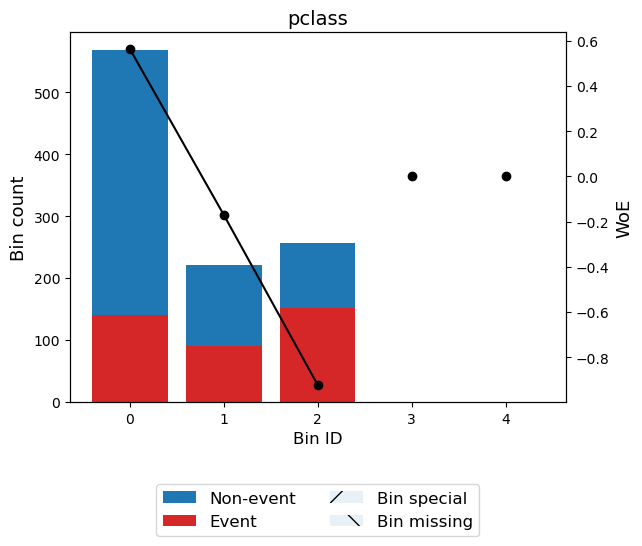

In [13]:
disc_pclass = utils.CustomDiscretizer(variable='pclass', dtype='categorical')
X_train['pclass_d'] = disc_pclass.fit_transform(X_train, y_train)
display(disc_pclass.binning_table.build())
disc_pclass.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[male],677,0.646609,559,118,0.174298,1.001098,0.532285,0.063889
1,[female],370,0.353391,106,264,0.713514,-1.466876,0.779940,0.089596
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1047,1.000000,665,382,0.364852,,1.312225,0.153485


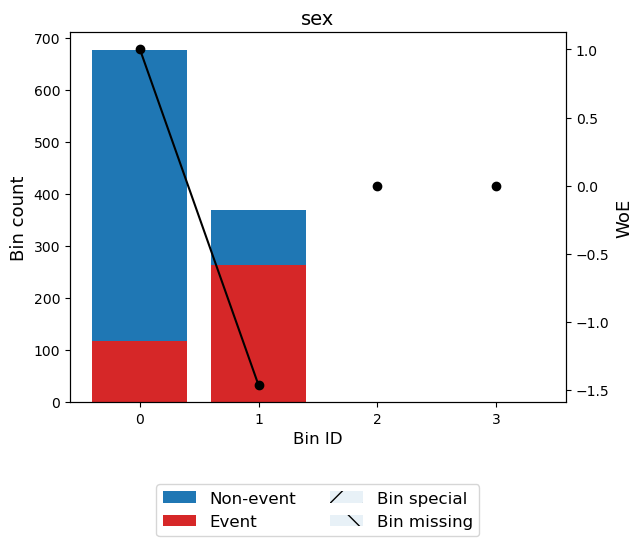

In [14]:
disc_sex = utils.CustomDiscretizer(variable='sex', dtype='categorical')
X_train['sex_d'] = disc_sex.fit_transform(X_train, y_train)
display(disc_sex.binning_table.build())
disc_sex.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[S],737,0.703916,503,234,0.317503,0.210903,0.030333,0.003785
1,[Q],100,0.095511,66,34,0.340000,0.108928,0.001116,0.000139
2,[C],209,0.199618,96,113,0.540670,-0.717406,0.108652,0.013297
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,1,0.000955,0,1,0.000000,0.0,0.000000,0.000000
Totals,,1047,1.000000,665,382,0.364852,,0.140101,0.017222


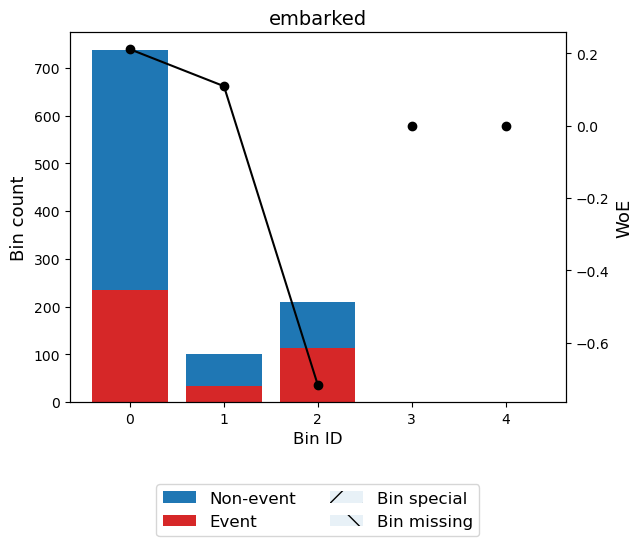

In [15]:
disc_embarked = utils.CustomDiscretizer(variable='embarked', dtype='categorical')
X_train['embarked_d'] = disc_embarked.fit_transform(X_train, y_train)
display(disc_embarked.binning_table.build())
disc_embarked.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Don, Jonkheer, Major, Rev, Mr]",615,0.587393,528,87,0.141463,1.248822,0.707128,0.083061
1,"[Col, Dr, Master, Ms]",64,0.061127,32,32,0.500000,-0.554366,0.019763,0.002439
2,[Miss],210,0.200573,71,139,0.661905,-1.22616,0.315255,0.037110
3,"[Mrs, Lady, Mlle, Mme, Sir]",157,0.149952,34,123,0.783439,-1.84019,0.498437,0.054776
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,1,0.000955,0,1,0.000000,0.0,0.000000,0.000000
Totals,,1047,1.000000,665,382,0.364852,,1.540583,0.177386


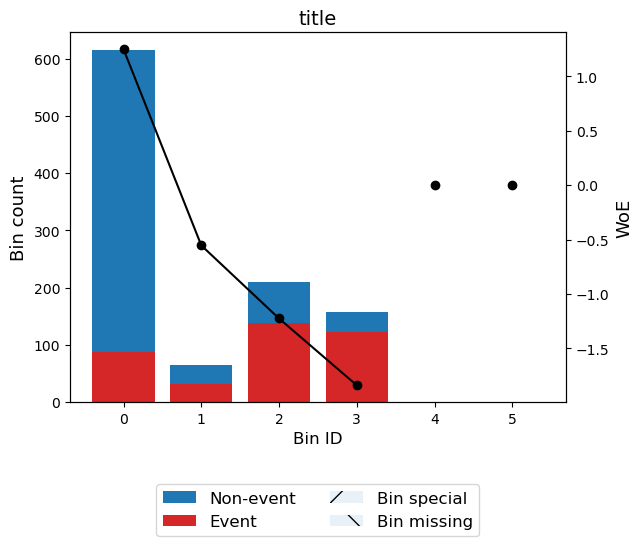

In [16]:
disc_title = utils.CustomDiscretizer(variable='title', dtype='categorical')
X_train['title_d'] = disc_title.fit_transform(X_train, y_train)
display(disc_title.binning_table.build())
disc_title.binning_table.plot()

In [17]:
X_train.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title,pclass_d,sex_d,embarked_d,title_d
772,3,male,17.0,0,0,NaN,S,Mr,0.563114,1.001098,0.210903,1.248822
543,2,male,36.0,0,0,NaN,S,Mr,-0.171374,1.001098,0.210903,1.248822
289,1,female,18.0,0,2,E,S,Miss,-0.924287,-1.466876,0.210903,-1.226160
10,1,male,47.0,1,0,C,C,Col,-0.924287,1.001098,-0.717406,-0.554366
147,1,male,NaN,0,0,NaN,S,Mr,-0.924287,1.001098,0.210903,1.248822


In [18]:
preprocessor = FunctionTransformer(preprocessing)
X_test = preprocessor.fit_transform(X_test)
X_test.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
1148,3,male,35.0,0,0,NaN,S,Mr
1049,3,male,20.0,1,1,NaN,C,Mr
982,3,male,NaN,0,0,NaN,S,Mr
808,3,male,NaN,0,0,NaN,S,Mr
1195,3,male,NaN,0,0,NaN,Q,Mr


In [19]:
X_test['pclass_d'] = disc_pclass.transform(X_test)
X_test['sex_d'] = disc_sex.transform(X_test)
X_test['embarked_d'] = disc_embarked.transform(X_test)
X_test['title_d'] = disc_title.transform(X_test)

In [20]:
vars = ['sibsp', 'parch', 'pclass_d', 'sex_d', 'embarked_d', 'title_d']
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train[vars], y_train)
y_preds = model_lr.predict_proba(X_train[vars])[:,1]
roc_auc_train = metrics.roc_auc_score(y_train, y_preds)
print(f"AUC Train: {roc_auc_train:0.2%}")

y_preds = model_lr.predict_log_proba(X_test[vars])[:,1]
roc_auc_test = metrics.roc_auc_score(y_test, y_preds)
print(f"AUC Test: {roc_auc_test:0.2%}")

AUC Train: 84.89%
AUC Test: 84.74%


### Create machine learning pipline

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.2,
                                                    random_state=42)

In [22]:
# Create a pipeline with Preprocessor, CustomDiscretizer and LogisticRegression
pipeline = Pipeline([
    ('preprocessing', FunctionTransformer()),
    ('disc_pclass', utils.CustomDiscretizer(variable='pclass', dtype='categorical')),
    ('disc_sex', utils.CustomDiscretizer(variable='sex', dtype='categorical')),
    ('disc_embarked', utils.CustomDiscretizer(variable='embarked', dtype='categorical')),
    ('disc_title', utils.CustomDiscretizer(variable='title', dtype='categorical')),
    ('classifier', LogisticRegression(random_state=42))
])

In [23]:
pipeline.fit_predict(X_train, y_train)

AttributeError: 'LogisticRegression' object has no attribute 'fit_predict'

In [138]:
from optbinning import OptimalBinning

preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.transform(X_train)

variable = 'title'
x = X_train[variable].values
y = y_train
optb = OptimalBinning(name=variable, dtype="categorical", solver="cp", max_n_bins=10, min_bin_size=0.05)
optb.fit(x, y)

OptimalBinning(dtype='categorical', max_n_bins=10, min_bin_size=0.05,
               name='title')

In [139]:
print(f"optb.status = {optb.status}")
print(f"optb.splits = {optb.splits}")
binning_table = optb.binning_table
binning_table.build()

optb.status = OPTIMAL
optb.splits = [array(['Don', 'Jonkheer', 'Major', 'Rev', 'Mr'], dtype=object), array(['Col', 'Dr', 'Master', 'Ms'], dtype=object), array(['Miss'], dtype=object), array(['Mrs', 'Lady', 'Mlle', 'Mme', 'Sir'], dtype=object)]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Don, Jonkheer, Major, Rev, Mr]",615,0.587393,528,87,0.141463,1.248822,0.707128,0.083061
1,"[Col, Dr, Master, Ms]",64,0.061127,32,32,0.500000,-0.554366,0.019763,0.002439
2,[Miss],210,0.200573,71,139,0.661905,-1.22616,0.315255,0.037110
3,"[Mrs, Lady, Mlle, Mme, Sir]",157,0.149952,34,123,0.783439,-1.84019,0.498437,0.054776
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,1,0.000955,0,1,0.000000,0.0,0.000000,0.000000
Totals,,1047,1.000000,665,382,0.364852,,1.540583,0.177386


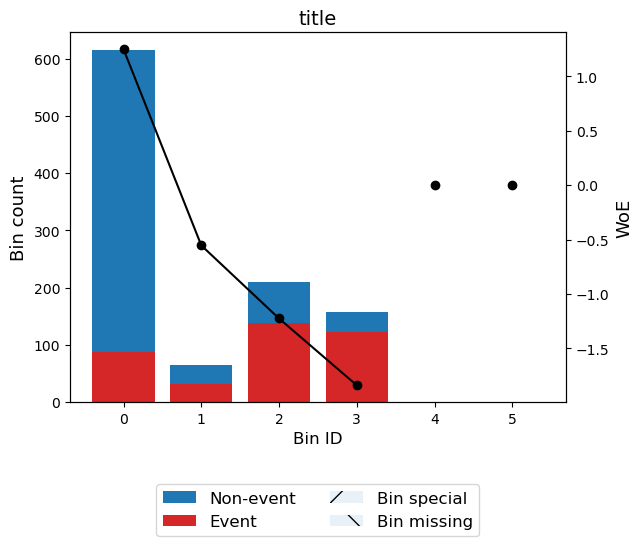

In [140]:
binning_table.plot(metric="woe")